# Digital Text II Final Project - O. Henry Short Stories Analysis

Student Name: Yutong Liu

Research Question: Do O. Henry’s characters reflect stereotypes of early 20th-century America?

Data source: The ohenry_texts corpus

Methods: NER; Word2Vec; LDA


## Installations

In [1]:
! pip install gensim
! pip install bertopic
! pip install pandas numpy scikit-learn matplotlib seaborn nltk
! pip install spacy
! pip install umap-learn hdbscan sentence-transformers
! pip install pyvis
! pip install pyLDAvis
! pip install top2vec
! python3.10 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 761.3 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Method 1: Named Entity Recognition

## Step 1: Get the top characters

In [2]:
import spacy
from collections import Counter
import os

nlp = spacy.load("en_core_web_sm")

folder_path = "./ohenry_texts"
texts = []

for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
            texts.append(f.read())

all_text = " ".join(texts)
doc = nlp(all_text)

characters = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]

char_counts = Counter(characters)
print("Top characters:", char_counts.most_common(10))


Top characters: [('David', 68), ('Bill', 55), ('Jimmy', 38), ('Andy', 26), ('Jim', 24), ('Geddie', 24), ('Sue', 23), ('Anthony', 20), ('Soapy', 15), ('Richard', 15)]


## Step 2: Extract adjectives near characters as "character feature" labels

In [3]:
from collections import defaultdict

char_adj = defaultdict(list)

for ent in doc.ents:
    if ent.label_ == "PERSON":
        sent = ent.sent
        adjs = [token.text.lower() for token in sent if token.pos_ == "ADJ"]
        char_adj[ent.text].extend(adjs)

char_adj_counts = {char: Counter(adjs) for char, adjs in char_adj.items()}
print(char_adj_counts)


{'Jimmy Valentine': Counter({'front': 2, 'retrieved': 1, 'many': 1, 'worth': 1, 'little': 1, 'black': 1}), 'Jimmy': Counter({'young': 3, 'old': 3, 'next': 2, 'alive': 2, 'tired': 1, 'other': 1, 'innocent': 1, 'virtuous': 1, 'green': 1, 'right': 1, 'fine': 1, 'complete': 1, 'latest': 1, 'puzzled': 1, 'short': 1, 'athletic': 1, 'senior': 1, 'scarce': 1, 'specious': 1, 'safe': 1, 'married': 1, 'little': 1, 'lively': 1, 'large': 1, 'full': 1, 'pet': 1, 'strange': 1, 'only': 1, 'truest': 1, 'stanchest': 1}), 'Valentine': Counter({'neat': 1, 'safe': 1, 'long': 1, 'quick': 1, 'good': 1, 'successful': 1}), 'James Valentine': Counter(), 'Mike Dolan': Counter({'alone': 1}), 'Mike': Counter({'alone': 1, 'same': 1}), "Ben Price's": Counter({'eminent': 1, 'high': 1}), 'Logansport': Counter({'burglar': 1, 'safe': 1, 'untouched': 1}), 'Ben Price': Counter({'next': 1, 'short': 1, 'elusive': 1, 'other': 1, 'burglar': 1, 'proof': 1}), "Dandy Jim Valentine's": Counter(), 'Polly Simpson': Counter({'young'

## Step 3: Combining stereotype keywords

In [4]:
stereotype_keywords = {"greedy", "lazy", "honest", "poor", "immigrant", "rich", "kind", "cunning", "naive", "hardworking"}

char_stereotype_counts = {}

for char, adj_counts in char_adj_counts.items():
    filtered = {word: count for word, count in adj_counts.items() if word in stereotype_keywords}
    if filtered:
        char_stereotype_counts[char] = filtered

print("Characters with stereotype-related adjectives:")
for char, counts in char_stereotype_counts.items():
    print(f"{char}: {counts}")


Characters with stereotype-related adjectives:
Andy: {'honest': 1}
Jack: {'kind': 1}
Ranse: {'kind': 1}
David: {'lazy': 1, 'poor': 1}
Sue: {'poor': 1}
Johnsy: {'poor': 1}
Sudie: {'greedy': 1}
Ach: {'poor': 1}


## Step 4: Visualizing it - Heatmap

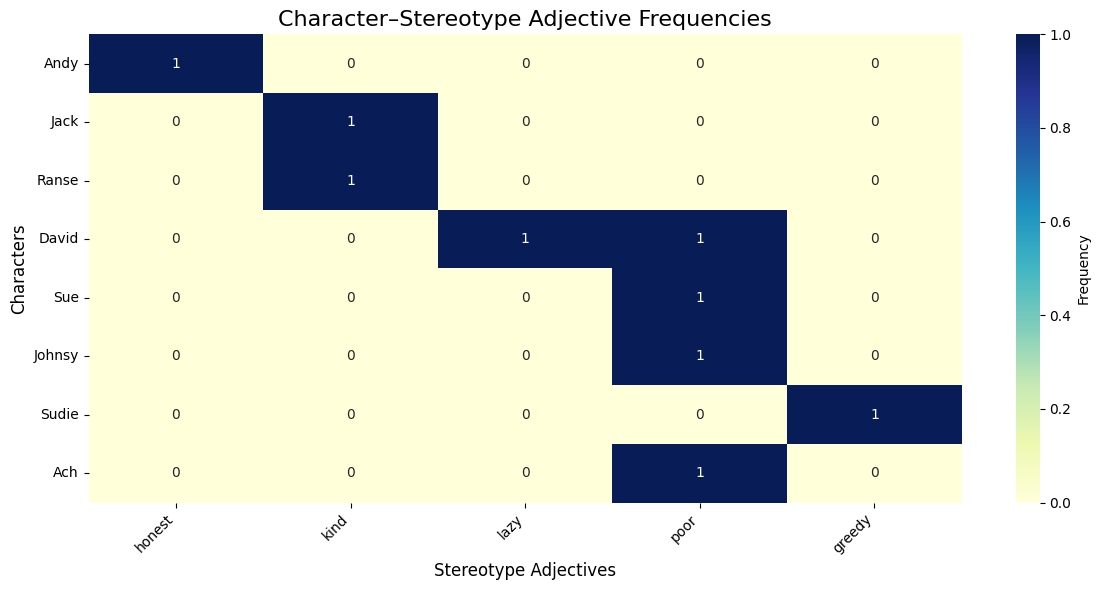

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(char_stereotype_counts).fillna(0).astype(int).T

plt.figure(figsize=(12, max(6, len(df) * 0.5)))
sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title("Character–Stereotype Adjective Frequencies", fontsize=16)
plt.xlabel("Stereotype Adjectives", fontsize=12)
plt.ylabel("Characters", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Method 2: Word2Vec

## Step 1: Load and preprocess text

In [6]:
import os
import spacy

stereotype_keywords = {"greedy", "lazy", "honest", "poor", "immigrant", "rich", "kind", "cunning", "naive", "hardworking"}
folder_path = "./ohenry_texts"
texts = []
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), encoding="utf-8") as f:
            texts.append(f.read())
all_text = " ".join(texts)

nlp = spacy.load("en_core_web_sm")
doc = nlp(all_text)
sentences = [
    [token.text.lower() for token in sent if not token.is_punct and not token.is_space]
    for sent in doc.sents
]

## Step 2: Train Word2Vec and collect similar words

In [7]:
from gensim.models import Word2Vec
from collections import defaultdict

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
valid_keywords = [w for w in stereotype_keywords if w in w2v_model.wv]

similar_words = defaultdict(list)
for word in valid_keywords:
    sims = w2v_model.wv.most_similar(word, topn=5)
    similar_words[word] = sims  

for keyword, sims in similar_words.items():
    print(f"Keyword: {keyword}")
    for sim_word, score in sims:
        print(f"  Similar word: {sim_word}, similarity: {score:.4f}")
    print()


Keyword: greedy
  Similar word: ago, similarity: 0.9127
  Similar word: james, similarity: 0.9114
  Similar word: stuff, similarity: 0.9112
  Similar word: professional, similarity: 0.9109
  Similar word: rolling, similarity: 0.9107

Keyword: cunning
  Similar word: conspirators, similarity: 0.7900
  Similar word: scarifying, similarity: 0.7778
  Similar word: sing, similarity: 0.7635
  Similar word: whiskers, similarity: 0.7630
  Similar word: depreca-, similarity: 0.7615

Keyword: poor
  Similar word: toward, similarity: 0.9971
  Similar word: between, similarity: 0.9970
  Similar word: which, similarity: 0.9970
  Similar word: dollars, similarity: 0.9970
  Similar word: him, similarity: 0.9970

Keyword: rich
  Similar word: smoke, similarity: 0.9920
  Similar word: them, similarity: 0.9917
  Similar word: air, similarity: 0.9917
  Similar word: much, similarity: 0.9916
  Similar word: saw, similarity: 0.9916

Keyword: honest
  Similar word: hardly, similarity: 0.9709
  Similar word:

## Step 3: Visualizing it - Semantic Space plot

In [8]:
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

words_to_plot = set(valid_keywords)
for sims in similar_words.values():
    for w, _ in sims:
        if w in w2v_model.wv:
            words_to_plot.add(w)
words_to_plot = list(words_to_plot)

vectors = [w2v_model.wv[w] for w in words_to_plot]

pca = PCA(n_components=2)
result = pca.fit_transform(vectors)
df = pd.DataFrame({
    'word': words_to_plot,
    'x': result[:, 0],
    'y': result[:, 1]
})
fig = px.scatter(df, x='x', y='y', text='word', title='Word2Vec Semantic Space Interactive Plot')
fig.update_traces(marker=dict(size=10),
                  selector=dict(mode='markers'),
                  hovertemplate='<b>%{text}</b><extra></extra>')
fig.show()


# Method 3: LDA Topic Modeling

## Step 1: Train the LDA Model

In [9]:
import os
import spacy
from gensim import corpora
from gensim.models import LdaModel

folder_path = "./ohenry_texts"
texts = []
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), encoding="utf-8") as f:
            texts.append(f.read())
all_text = " ".join(texts)

nlp = spacy.load("en_core_web_sm")
doc = nlp(all_text)
sentences = [
    [token.lemma_.lower() for token in sent 
     if not token.is_punct and not token.is_space and not token.is_stop]
    for sent in doc.sents
]

dictionary = corpora.Dictionary(sentences)
corpus = [dictionary.doc2bow(text) for text in sentences]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)
for i in range(5):
    print(f"Topic {i}:")
    print(lda.print_topic(i, topn=10))
    print()


Topic 0:
0.020*"say" + 0.012*"time" + 0.007*"little" + 0.007*"kid" + 0.007*"leave" + 0.007*"know" + 0.006*"poet" + 0.006*"think" + 0.005*"come" + 0.005*"shall"

Topic 1:
0.010*"man" + 0.009*"dollar" + 0.009*"hand" + 0.006*"eye" + 0.006*"little" + 0.006*"hour" + 0.006*"take" + 0.006*"open" + 0.006*"bill" + 0.006*"say"

Topic 2:
0.008*"look" + 0.007*"man" + 0.005*"kid" + 0.005*"window" + 0.005*"david" + 0.005*"eye" + 0.004*"step" + 0.004*"hear" + 0.004*"kill" + 0.004*"come"

Topic 3:
0.012*"go" + 0.011*"get" + 0.009*"night" + 0.008*"say" + 0.007*"day" + 0.007*"find" + 0.006*"old" + 0.005*"like" + 0.004*"look" + 0.004*"live"

Topic 4:
0.029*"say" + 0.009*"come" + 0.008*"look" + 0.007*"bill" + 0.007*"like" + 0.006*"want" + 0.006*"eye" + 0.006*"man" + 0.006*"ask" + 0.006*"mr."



## Step 2: Visualize the topics - pyLDAvis

In [10]:
## I learned this method and editted the code on Chatgpt.
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(vis_data, 'lda_vis.html')